I denne notatboken viser jeg tydelig prosessen rundt om å sette opp:
- Colab med Google Driven min
- Å gi VM'en i Colab tilgang til Kaggle gjennom min personlige Token
- Hvordan vi laster ned datasettet og den relaterte fil-strukturen
- Behandlingen av datasettet som trengs før trening
- Modellens arkitektur samt hyperparameterene (BiDir LSTM)
- Treningen av modellen, med målinger for hver Epoch
- Hvordan vi lagrer den beste modellen
- Til slutt bruker vi metrics som val_loss, confusion matrix, ROC score, f1 score etc til å "benchmarke" modellen vi har trent

Alle kommentarene er skrevet på engelsk

NB: I noen celler har jeg skrevet mye flere kommentarer enn i andre; dette er for min egen læring.

In [4]:
# Cell 1a: Installing Kaggle library (Kaggle's API Client)
!pip install kaggle -q # -q to avoid excessive output

In [5]:
# Cell 1b: Setting up Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

!ls /content/drive/MyDrive | head -n 5 # Show first 5 items, to make sure that I am in the correct drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Algorithms Illuminated (Part 1)_ The Basics .pdf
apostol-calculusi.pdf
Atlas Shrugged Analysis .gdoc
Colab_Exports
Colab Notebooks


In [6]:
# Cell 2: Uploading my Kaggle API token (kaggle.json)
from google.colab import files
import os

files.upload()

# Creating a dir to store the kaggle token
!mkdir -p ~/.kaggle
# Moving the uploaded file to that dir
!mv kaggle.json ~/.kaggle/
# Set the permissions so that we have programmatic access to everything on Kaggle, like datasets
!chmod 600 ~/.kaggle/kaggle.json
print("kaggle token setup done.")

Saving kaggle.json to kaggle.json
kaggle token setup done.


In [7]:
# Cell 3: Download and Unzip the Dataset
import os

# where to put the data
DATA_DIR = "kaggle_data"
# create the dir
!mkdir -p {DATA_DIR}

# Download the dataset and automatically unzip it into the DATA_DIR folder
# ! makes it so that the command is sent to the shell instead of the python interpreter
# The '-d' flag specifies the dataset name from Kaggle URL
# The '-p' flag specifies the path to download to
# The '--unzip' flag automatically unzips the file after download
!kaggle datasets download -d kritanjalijain/amazon-reviews -p {DATA_DIR} --unzip

# define the path to the training file (train.csv)
# assume 'train.csv' is directly inside the DATA_DIR after unzipping
csv_path = os.path.join(DATA_DIR, 'train.csv')

print(f"Dataset downloaded and unzipped into '{DATA_DIR}'.")
print(f"Path to train file is: {csv_path}")


!ls {DATA_DIR} # Shows us the downloaded files

Dataset URL: https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews
License(s): CC0-1.0
Dataset downloaded and unzipped into 'kaggle_data'.
Path to train file is: kaggle_data/train.csv
amazon_review_polarity_csv.tgz	test.csv  train.csv


In [8]:
# Cell 4: Imports for Data Handling and Preprocessing
import pandas as pd
import numpy as np
import re # For regular expressions used in cleaning
import nltk # Natural Language Toolkit for stopwords

nltk.download('stopwords', quiet=True)

from nltk.corpus import stopwords

print("\nNLTK stopwords are ready; Libraries imported.")


NLTK stopwords are ready; Libraries imported.


In [9]:
# Cell 4a: Peaking at the data
col_names = ['label', 'title', 'content']
df_peak = pd.read_csv(csv_path, header=None, names=col_names)

print(df_peak.head(3))

print("\nShape: ", df_peak.shape)

# 1 means negative, 2 means positive
print(df_peak['label'].value_counts())

print("\nShare of positive reviews:", round((df_peak['label'] == 2).mean()*100, 2), "%")

df_peak['review_len'] = df_peak['content'].str.len()
print("\nAverage characters per review:",
      int(df_peak['review_len'].mean()))

   label                                  title  \
0      2         Stuning even for the non-gamer   
1      2  The best soundtrack ever to anything.   
2      2                               Amazing!   

                                             content  
0  This sound track was beautiful! It paints the ...  
1  I'm reading a lot of reviews saying that this ...  
2  This soundtrack is my favorite music of all ti...  

Shape:  (3600000, 3)
label
2    1800000
1    1800000
Name: count, dtype: int64

Share of positive reviews: 50.0 %

Average characters per review: 405


In [10]:
# Cell 4b
review_lens = df_peak['content'].str.count(' ') + 1
review_lens.describe(percentiles=[.5, .9, .95]) # Real‑world text‑length distributions are long‑tailed, which informs our wanted percentiles

,content
count,3.600000e+06
mean,7.416885e+01
std,4.229871e+01
min,1.000000e+00
50%,6.600000e+01
90%,1.390000e+02
95%,1.560000e+02
max,2.540000e+02


In [22]:
# Cell 5: Configuration Parameters
import os

print(f"Using data from: {csv_path}")


NROWS_TO_LOAD = 200000

COLUMN_NAMES = ["polarity", "title", "text"]

# Tokenization & Padding
VOCAB_SIZE = 12000
MAX_SEQUENCE_LENGTH = 80
OOV_TOKEN = "<OOV>"

# Model Parameters
EMBEDDING_DIM = 128
LSTM_UNITS = 128
DROPOUT_RATE = 0.4

# Training Parameters
VALIDATION_SPLIT_SIZE = 0.20
TEST_SPLIT_SIZE = 0.20
RANDOM_STATE = 42
EPOCHS = 6
BATCH_SIZE = 64
LEARNING_RATE = 0.0007


# Define the main dir to save artifacts for this model
MODEL_ARTIFACTS_DIR = "models_rnn_lstm_bidir"
# Create the dir if it doesn't exist
os.makedirs(MODEL_ARTIFACTS_DIR, exist_ok=True)

# Permanent storage on google drive
GDRIVE_SAVE_DIR = '/content/drive/MyDrive/Sentiment Analysis Project/LSTM_bidir_Results_'

# Define specific file paths using the directory above
MODEL_SAVE_PATH = os.path.join(MODEL_ARTIFACTS_DIR, "best_lstm_bidir_model.keras")
TOKENIZER_SAVE_PATH = os.path.join(MODEL_ARTIFACTS_DIR, "tokenizer_lstm_bidir.pickle")
HISTORY_PLOT_SAVE_PATH = os.path.join(MODEL_ARTIFACTS_DIR, "training_history_lstm.png")

print("LSTM configuration set.")
print(f"Artifacts will be saved in: {MODEL_ARTIFACTS_DIR}")

Using data from: kaggle_data/train.csv
LSTM configuration set.
Artifacts will be saved in: models_rnn_lstm_bidir


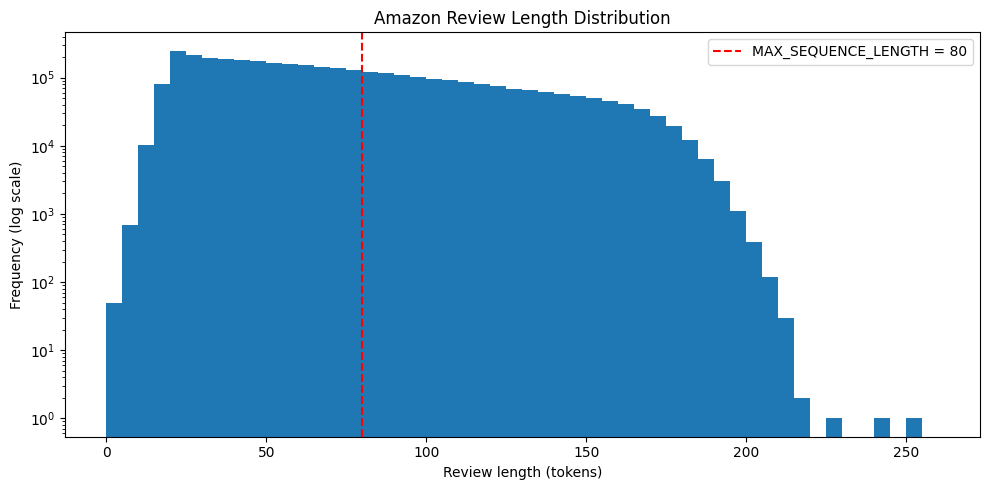

In [12]:
# Cell 5b
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
bins = np.arange(0, 260+5, 5)
plt.hist(review_lens, bins=bins, log=True)
plt.axvline(MAX_SEQUENCE_LENGTH, color='red', ls='--',
            label=f'MAX_SEQUENCE_LENGTH = {MAX_SEQUENCE_LENGTH}')
plt.xlabel('Review length (tokens)')
plt.ylabel('Frequency (log scale)')
plt.title('Amazon Review Length Distribution')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Cell 6: Load Data with Pandas
print(f"Loading data from '{csv_path}'...")

# Load the CSV using pandas
# header=None: Tells pandas the file doesn't have a header row
# names=COLUMN_NAMES: Provides the names we defined in Cell 5 for the columns
# nrows=NROWS_TO_LOAD: Limits the number of rows read (for speed during development)
df = pd.read_csv(
    csv_path,
    header=None,
    names=COLUMN_NAMES,
    nrows=NROWS_TO_LOAD
)
print("Data loaded into DataFrame.")

print("\nDataFrame Info:")
df.info() # Shows column types, non-null counts, memory usage

print("\nFirst 5 rows:")
print(df.head()) # Look at the actual data values.

print("\nMissing values per column:")
print(df.isnull().sum()) # Check how many missing values are in each column

# Handle missing values in columns ('title', 'text')
# inplace=True modifies the DataFrame directly without creating a copy
df.dropna(subset=['title', 'text'], inplace=True)
print(f"\nShape after dropping rows with missing title/text: {df.shape}")

Loading data from 'kaggle_data/train.csv'...
Data loaded into DataFrame.

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   polarity  200000 non-null  int64 
 1   title     199982 non-null  object
 2   text      200000 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.6+ MB

First 5 rows:
   polarity                                              title  \
0         2                     Stuning even for the non-gamer   
1         2              The best soundtrack ever to anything.   
2         2                                           Amazing!   
3         2                               Excellent Soundtrack   
4         2  Remember, Pull Your Jaw Off The Floor After He...   

                                                text  
0  This sound track was beautiful! It paints the ...  
1  I'm reading a lot of reviews s

In [14]:
# Cell 7: Basic Text Cleaning
print("Cleaning text data...")

# Combine title and text
# Often, combining the review title and body gives the model more context
# We create a new column 'full_review'
df['full_review'] = df['title'] + ' ' + df['text']

# Define the cleaning function
# This function performs common text normalization steps
def clean_text(text):
    text = str(text).lower()
    # [^a-z0-9\s] means "match anything that is not a lowercase letter, a digit, or whitespace
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Remove extra whitespace (multiple spaces/tabs/newlines)
    # \s+ means "match one or more whitespace characters"
    text = re.sub(r'\s+', ' ', text).strip() # .strip() removes leading/trailing whitespace
    return text

# .apply() runs the 'clean_text' function on every entry in the 'full_review' column
# store the result in a new column 'cleaned_review'
# Using .astype(str) ensures apply works correctly even if 'full_review' had non-string data
df['cleaned_review'] = df['full_review'].astype(str).apply(clean_text)

print("Text cleaning applied.")

# displaying some samples
print("\nSample original vs cleaned reviews:")
print(df[['full_review', 'cleaned_review']].head())

Cleaning text data...
Text cleaning applied.

Sample original vs cleaned reviews:
                                         full_review  \
0  Stuning even for the non-gamer This sound trac...   
1  The best soundtrack ever to anything. I'm read...   
2  Amazing! This soundtrack is my favorite music ...   
3  Excellent Soundtrack I truly like this soundtr...   
4  Remember, Pull Your Jaw Off The Floor After He...   

                                      cleaned_review  
0  stuning even for the nongamer this sound track...  
1  the best soundtrack ever to anything im readin...  
2  amazing this soundtrack is my favorite music o...  
3  excellent soundtrack i truly like this soundtr...  
4  remember pull your jaw off the floor after hea...  


In [15]:
# Cell 8: Remove Stopwords
print("Removing stopwords...")

stop_words = set(stopwords.words('english')) #

def remove_stopwords(text):
    words = text.split()
    # create a new list keeping only words that are NOT in the stop_words set
    filtered_words = [word for word in words if word not in stop_words]
    # join the filtered words back into a single string separated by spaces
    return ' '.join(filtered_words)


df['cleaned_review_no_stopwords'] = df['cleaned_review'].apply(remove_stopwords)

print("Stopwords removed.")

# comparison
print("\nSample reviews after stopword removal:")
print(df[['cleaned_review', 'cleaned_review_no_stopwords']].head())

FINAL_TEXT_COLUMN = 'cleaned_review_no_stopwords'
print(f"\nUsing column '{FINAL_TEXT_COLUMN}' for subsequent tokenization.")

Removing stopwords...
Stopwords removed.

Sample reviews after stopword removal:
                                      cleaned_review  \
0  stuning even for the nongamer this sound track...   
1  the best soundtrack ever to anything im readin...   
2  amazing this soundtrack is my favorite music o...   
3  excellent soundtrack i truly like this soundtr...   
4  remember pull your jaw off the floor after hea...   

                         cleaned_review_no_stopwords  
0  stuning even nongamer sound track beautiful pa...  
1  best soundtrack ever anything im reading lot r...  
2  amazing soundtrack favorite music time hands i...  
3  excellent soundtrack truly like soundtrack enj...  
4  remember pull jaw floor hearing youve played g...  

Using column 'cleaned_review_no_stopwords' for subsequent tokenization.


In [16]:
# Cell 9: prepare Final Features (X) and Labels (y)

X = df[FINAL_TEXT_COLUMN]
print(f"Selected features (X) from column: '{FINAL_TEXT_COLUMN}'")

# create the binary labels (0 or 1) ---
# Map polarity score (1 for neg, 2 for pos) to label (0 for neg, 1 for pos)
df['label'] = df['polarity'].map({1: 0, 2: 1})
y = df['label']
print("Created labels (y) by mapping polarity {1:0, 2:1}.")

# check for any missing labels after mapping
if y.isnull().sum() > 0:
    print(f"Warning: Found {y.isnull().sum()} missing values in labels after mapping.")
    print("Dropping rows with missing labels and corresponding features.")
    # Get indices of rows where label is not null
    valid_indices = y.notnull()
    # Keep only rows with valid labels in both X and y
    X = X[valid_indices]
    y = y[valid_indices]
    print("Rows with missing labels dropped.")
else:
    print("No missing labels found after mapping.")

# final check
print(f"\nFinal Features (X) shape: {X.shape}")
print(f"Final Labels (y) shape: {y.shape}")
# Ensure they still have the same number of entries
assert X.shape[0] == y.shape[0], "Mismatch between number of features and labels!"
print(f"Label distribution:\n{y.value_counts(normalize=True)}")

Selected features (X) from column: 'cleaned_review_no_stopwords'
Created labels (y) by mapping polarity {1:0, 2:1}.
No missing labels found after mapping.

Final Features (X) shape: (199982,)
Final Labels (y) shape: (199982,)
Label distribution:
label
1    0.505841
0    0.494159
Name: proportion, dtype: float64


In [17]:
# Cell 10: Split Data into Training, Validation, and Test Sets

# use scikit-learn's train_test_split function
from sklearn.model_selection import train_test_split

# Split 1: Separate Validation Set
# This takes the full X and y and splits off the validation set first
# stratify=y ensures that the proportion of positive/negative labels is
# approximately the same in the output splits as in the input 'y'.
X_train_temp, X_val, y_train_temp, y_val = train_test_split(
    X, y,
    test_size=VALIDATION_SPLIT_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
print("First split complete (Train+Test vs Validation).")

# Split 2: Separate Test Set
# This takes the *remaining* data (X_train_temp, y_train_temp) and splits off
# the test set. TEST_SPLIT_SIZE=0.25 means 25% of the first split's
# training portion (which was 80% of total) becomes the test set (0.25 * 0.80 = 0.20 of total).
# This results in the desired 60% Train, 20% Validation, 20% Test split overall.
X_train, X_test, y_train, y_test = train_test_split(
    X_train_temp, y_train_temp,
    test_size=TEST_SPLIT_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_train_temp
)
print("Second split complete (Train vs Test).")

print("\nFinal Data Split Sizes:")
print(f"Training set:   X_train shape={X_train.shape}, y_train shape={y_train.shape}")
print(f"Validation set: X_val shape={X_val.shape}, y_val shape={y_val.shape}")
print(f"Test set:       X_test shape={X_test.shape}, y_test shape={y_test.shape}")

First split complete (Train+Test vs Validation).
Second split complete (Train vs Test).

Final Data Split Sizes:
Training set:   X_train shape=(127988,), y_train shape=(127988,)
Validation set: X_val shape=(39997,), y_val shape=(39997,)
Test set:       X_test shape=(31997,), y_test shape=(31997,)


In [18]:
# Cell 11: Tokenization and Padding

# Import Keras utilities
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle # To save the tokenizer

print("Starting tokenization and padding...")

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

# fit the Tokenizer on train data only
print("Fitting tokenizer on training data...")
tokenizer.fit_on_texts(X_train)

# convert text to sequences of integers
print("Converting text to sequences...")
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# pad the sequences
print(f"Padding sequences to length: {MAX_SEQUENCE_LENGTH}")
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print("\nPadding complete.")
print(f"Padded Training sequence shape: {X_train_pad.shape}")
print(f"Padded Validation sequence shape: {X_val_pad.shape}")
print(f"Padded Test sequence shape: {X_test_pad.shape}")

# TOKENIZER_SAVE_PATH is defined in Cell5
print(f"\nSaving tokenizer to: {TOKENIZER_SAVE_PATH}")
with open(TOKENIZER_SAVE_PATH, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer saved.")

Starting tokenization and padding...
Fitting tokenizer on training data...
Converting text to sequences...
Padding sequences to length: 80

Padding complete.
Padded Training sequence shape: (127988, 80)
Padded Validation sequence shape: (39997, 80)
Padded Test sequence shape: (31997, 80)

Saving tokenizer to: models_rnn_lstm_bidir/tokenizer_lstm_bidir.pickle
Tokenizer saved.


In [23]:
# Cell 12: Bidirectional LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense,
    SpatialDropout1D, Bidirectional
)

print("\nBuilding the Bidirectional LSTM model architecture ...")

model = Sequential(name="BiLSTM_Sentiment_Model")

# 1) Embedding
model.add(Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_SEQUENCE_LENGTH,
    mask_zero=True
))

# 2) SpatialDropout to regularise embeddings
model.add(SpatialDropout1D(DROPOUT_RATE))

# 3) Bidirectional LSTM
model.add(
    Bidirectional(
        LSTM(
            units=LSTM_UNITS,
            dropout=DROPOUT_RATE,
            recurrent_dropout=0.0,   # keep CuDNN kernel fast
            return_sequences=False
        )
    )
)

# 4) Output layer
model.add(Dense(1, activation='sigmoid'))

print("\nModel built successfully.")
model.summary()

from tensorflow.keras.optimizers import Adam
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)
print("\nModel compiled.")



Building the Bidirectional LSTM model architecture ...

Model built successfully.


Model: "BiLSTM_Sentiment_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Model compiled.


In [24]:
# Cell 13: Compile the Model
import tensorflow as tf

print("\nCompiling the model...")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print("Model compiled.")


Compiling the model...
Model compiled.


In [25]:
# Cell 14: Define Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# MODEL_SAVE_PATH defined in Cell 5

print("Defining callbacks (EarlyStopping, ModelCheckpoint)...")

# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# Use the MODEL_SAVE_PATH from Cell 5
model_checkpoint = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH, # Use variable from Cell 5
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

callbacks_list = [early_stopping, model_checkpoint]
print(f"Callbacks defined. Best model will be saved to: {MODEL_SAVE_PATH}")

Defining callbacks (EarlyStopping, ModelCheckpoint)...
Callbacks defined. Best model will be saved to: models_rnn_lstm_bidir/best_lstm_bidir_model.keras


In [26]:
# Cell 15: Train the Model

print("\nStarting model training...")
print(f"Training data shape: {X_train_pad.shape}")
print(f"Validation data shape: {X_val_pad.shape}")
print(f"Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}")

# model.fit trains the model.
# Inputs: Padded training sequences (X_train_pad) and corresponding labels (y_train).
# epochs=EPOCHS: Maximum number of times to iterate over the entire training dataset.
# batch_size=BATCH_SIZE: Number of samples to process before updating model weights.
# validation_data: Data to evaluate the model on at the end of each epoch (X_val_pad, y_val).
# callbacks=callbacks_list: Use the EarlyStopping and ModelCheckpoint defined in cell13
# verbose=1: Show progress bars during training.
history = model.fit(
    X_train_pad, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val),
    callbacks=callbacks_list,
    verbose=1
)

print("\nTraining finished.")
print(f"Best model saved during training at: {MODEL_SAVE_PATH}")


Starting model training...
Training data shape: (127988, 80)
Validation data shape: (39997, 80)
Epochs: 6, Batch Size: 64
Epoch 1/6
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8326 - loss: 0.3665
Epoch 1: val_loss improved from inf to 0.27068, saving model to models_rnn_lstm_bidir/best_lstm_bidir_model.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.8326 - loss: 0.3665 - val_accuracy: 0.8912 - val_loss: 0.2707
Epoch 2/6
1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9068 - loss: 0.2313
Epoch 2: val_loss improved from 0.27068 to 0.25415, saving model to models_rnn_lstm_bidir/best_lstm_bidir_model.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.9068 - loss: 0.2313 - val_accuracy: 0.8946 - val_loss: 0.2541
Epoch 3/6
1996/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9193 - loss: 0.2050
Epoch 3: val_loss did not improve from 0.25415
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.9193 - loss: 0.2050 - val_accurac


Plotting training history (Accuracy and Loss)...
Training history plot saved to: models_rnn_lstm_bidir/training_history_lstm_bidir.png


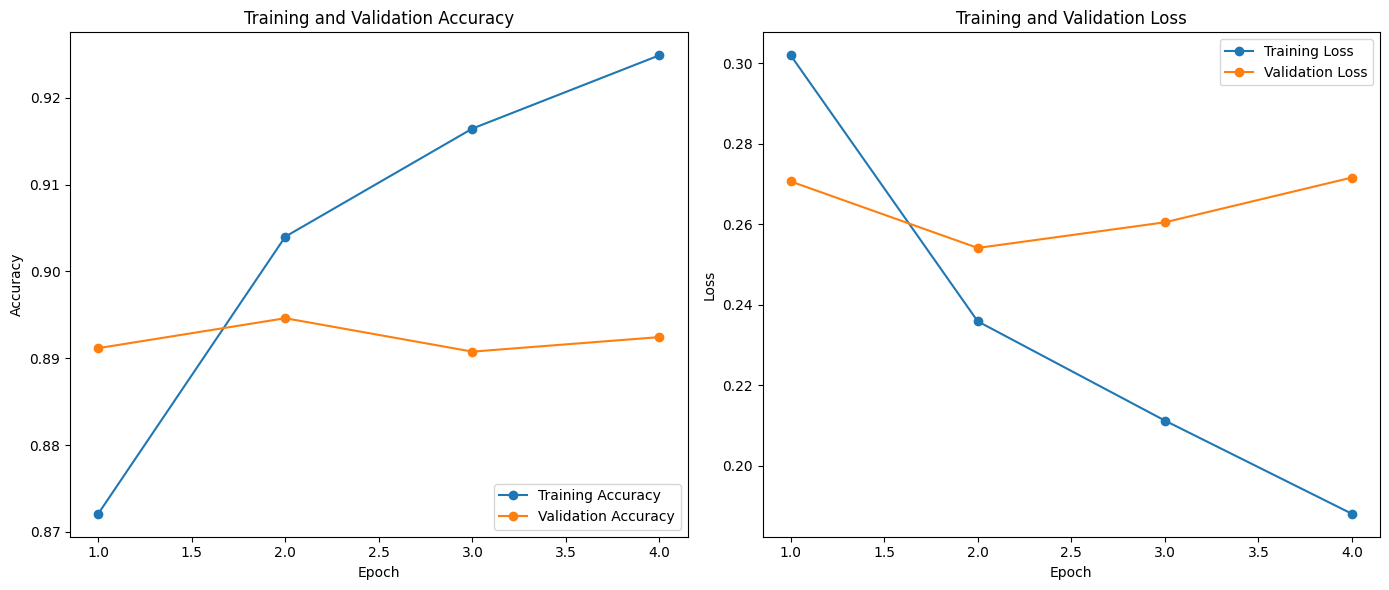


--- GRU Model Training Stage Complete ---


In [27]:
# Cell 16: Training History

# Path to save the plot (using dir from Cell 5)
HISTORY_PLOT_SAVE_PATH = os.path.join(MODEL_ARTIFACTS_DIR, "training_history_lstm_bidir.png")

print("\nPlotting training history (Accuracy and Loss)...")

def plot_training_history(history, save_path=None):
    # metrics from history object
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    # the number of epochs actually run
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    # Accuracy
    plt.subplot(1, 2, 1) # 1 row, 2 columns, plot 1
    if acc: plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    if val_acc: plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(False)

    # Loss
    plt.subplot(1, 2, 2) # 1 row, 2 columns, plot 2
    if loss: plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    if val_loss: plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(False)

    # Adjust layout and show/save
    plt.tight_layout()
    if save_path:
        try:
             plt.savefig(save_path)
             print(f"Training history plot saved to: {save_path}")
        except Exception as e:
             print(f"Error saving plot: {e}")
    plt.show()


# Check if history object exists and has history attribute
if 'history' in locals() and hasattr(history, 'history'):
    plot_training_history(history, save_path=HISTORY_PLOT_SAVE_PATH)
else:
    print("History object not found. Cannot plot training history.")

print("\n--- GRU Model Training Stage Complete ---")

In [28]:
# Cell 17: Load the Best Saved Model

print(f"Loading the best saved model from: {MODEL_SAVE_PATH}")
try:
    import tensorflow as tf
    best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    print("Best model loaded successfully.")
    # best_model.summary()
except Exception as e:
    print(f"Error loading saved model: {e}")
    print("Ensure training completed and the model file exists at the specified path.")
    best_model = model
    print("Using model currently in memory as fallback (might not be the best).")

Loading the best saved model from: models_rnn_lstm_bidir/best_lstm_bidir_model.keras
Best model loaded successfully.


In [29]:
# Cell 18: Evaluation Metrics

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

print("Evaluation libraries imported.")

Evaluation libraries imported.


In [30]:
# Cell 19: Predictions on Test Set

print("Generating predictions on the test set...")
# Use the loaded best_model to predict probabilities on the padded test data
# verbose=1 shows a progress bar
y_pred_probs = best_model.predict(X_test_pad, verbose=1)

# Convert probabilities (output of sigmoid, between 0 and 1) into class labels (0 or 1)
# use 0.5 as the threshold
y_pred = (y_pred_probs > 0.5).astype(int).flatten() # flatten ensures it's a 1D array

print("Predictions generated.")
print(f"Shape of probabilities (y_pred_probs): {y_pred_probs.shape}")
print(f"Shape of final predictions (y_pred): {y_pred.shape}")
print(f"Shape of true test labels (y_test): {y_test.shape}")

Generating predictions on the test set...
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Predictions generated.
Shape of probabilities (y_pred_probs): (31997, 1)
Shape of final predictions (y_pred): (31997,)
Shape of true test labels (y_test): (31997,)


In [31]:
# Cell 20: Classification Report and Confusion Matrix Values

print("\n Classification Report")
# Compares the true labels (y_test) with the predicted labels (y_pred)
# Shows precision, recall, f1-score for each class (Negative/Positive)
report = classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)'])
print(report)

print("\n Confusion Matrix")
# Calculates the confusion matrix:
# [[True Negative, False Positive],
#  [False Negative, True Positive]]
cm = confusion_matrix(y_test, y_pred)
print(cm)


 Classification Report
              precision    recall  f1-score   support

Negative (0)       0.88      0.91      0.90     15812
Positive (1)       0.91      0.88      0.89     16185

    accuracy                           0.90     31997
   macro avg       0.90      0.90      0.90     31997
weighted avg       0.90      0.90      0.90     31997


 Confusion Matrix
[[14452  1360]
 [ 1998 14187]]



Plotting Confusion Matrix...
Confusion matrix plot saved to: models_rnn_lstm_bidir/confusion_matrix.png


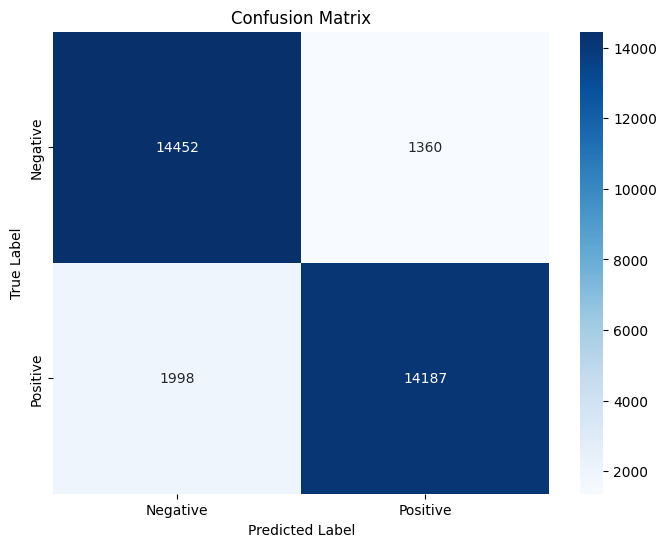

In [32]:
# Cell 21: Plot Confusion Matrix

CM_PLOT_SAVE_PATH = os.path.join(MODEL_ARTIFACTS_DIR, "confusion_matrix.png")

print("\nPlotting Confusion Matrix...")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Save the plot
try:
    plt.savefig(CM_PLOT_SAVE_PATH)
    print(f"Confusion matrix plot saved to: {CM_PLOT_SAVE_PATH}")
except Exception as e:
    print(f"Error saving plot: {e}")

plt.show()


Plotting ROC Curve...
Area Under ROC Curve (AUC): 0.9615
ROC curve plot saved to: models_rnn_lstm_bidir/roc_curve.png


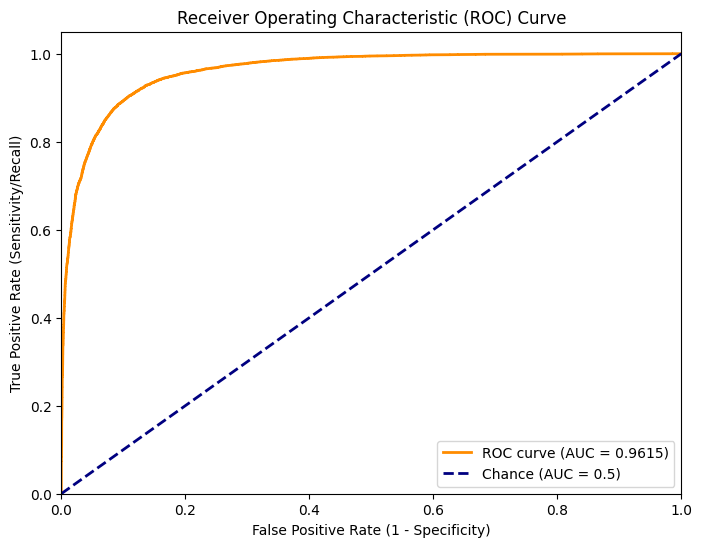

In [33]:
# Cell 22: Plot ROC Curve

ROC_PLOT_SAVE_PATH = os.path.join(MODEL_ARTIFACTS_DIR, "roc_curve.png")

print("\nPlotting ROC Curve...")

# Calculate ROC curve points
# Uses the true labels (y_test) and the (y_pred_probs)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)
print(f"Area Under ROC Curve (AUC): {roc_auc:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Save the plot
try:
    plt.savefig(ROC_PLOT_SAVE_PATH)
    print(f"ROC curve plot saved to: {ROC_PLOT_SAVE_PATH}")
except Exception as e:
    print(f"Error saving plot: {e}")

plt.show()

In [34]:
# Cell 23: Copy Results to Google Drive for Storage

print(f"\nAttempting to copy temporary results from '{MODEL_ARTIFACTS_DIR}'")
print(f"to permanent Google Drive location: '{GDRIVE_SAVE_DIR}'...")

# The '-p' flag means it won't complain if the dir already exists
!mkdir -p "{GDRIVE_SAVE_DIR}"

# Copy the entire temporary results folder to Google Drive
# The '-r' flag means recursive (copy folder and its contents)
# The '-v' flag means verbose (show files being copied)
!cp -r -v "{MODEL_ARTIFACTS_DIR}"/* "{GDRIVE_SAVE_DIR}"/

# Verify copy by listing contents of the Drive directory
print(f"\nContents of Google Drive save directory ('{GDRIVE_SAVE_DIR}'):")
!ls -lh "{GDRIVE_SAVE_DIR}"

print("\nCopy to Google Drive finished.")
print("The best model, tokenizer, plots, and metrics should now be saved permanently.")


Attempting to copy temporary results from 'models_rnn_lstm_bidir'
to permanent Google Drive location: '/content/drive/MyDrive/Sentiment Analysis Project/LSTM_bidir_Results_'...
'models_rnn_lstm_bidir/best_lstm_bidir_model.keras' -> '/content/drive/MyDrive/Sentiment Analysis Project/LSTM_bidir_Results_/best_lstm_bidir_model.keras'
'models_rnn_lstm_bidir/confusion_matrix.png' -> '/content/drive/MyDrive/Sentiment Analysis Project/LSTM_bidir_Results_/confusion_matrix.png'
'models_rnn_lstm_bidir/roc_curve.png' -> '/content/drive/MyDrive/Sentiment Analysis Project/LSTM_bidir_Results_/roc_curve.png'
'models_rnn_lstm_bidir/tokenizer_lstm_bidir.pickle' -> '/content/drive/MyDrive/Sentiment Analysis Project/LSTM_bidir_Results_/tokenizer_lstm_bidir.pickle'
'models_rnn_lstm_bidir/training_history_lstm_bidir.png' -> '/content/drive/MyDrive/Sentiment Analysis Project/LSTM_bidir_Results_/training_history_lstm_bidir.png'

Contents of Google Drive save directory ('/content/drive/MyDrive/Sentiment Analy